### https://www.dataquest.io/blog/pandas-big-data/

I read this blog and find it is very interesting to learn the stategy to reduce the memory consumption with pandas for large dataset processing. This blog introduces two ways, one is downcast numerical data and the other one is to transform object datatype. After this two processing stage, the memory usage can be reduced by 90% 

Keywords: memory usage can be reduced by up to 90%

In [1]:
import numpy as np
import pandas as pd

# load data set, which is available: https://data.world/dataquest/mlb-game-logs
data = pd.read_csv("game_logs.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# check memory usage information before processing 
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 738.1 MB


#### Downcast numerical data type(float64	int64	uint64 => float32	int32	uint32	 => float16	int16	uint16)

In [3]:
# downcast int type columns in pandas
data_int = data.select_dtypes(include=['int'])
converted_int = data_int.apply(pd.to_numeric, downcast='unsigned')

# compare the difference
compared_int = pd.concat([data_int.dtypes, converted_int.dtypes], axis=1)
compared_int.columns = ['Before', 'After']
compared_int.apply(pd.Series.value_counts)

,Before,After
uint8,NaN,5.0
uint32,NaN,1.0
int64,6.0,NaN


In [4]:
# downcast float type columns in pandas
data_float = data.select_dtypes(include=['float'])
converted_float = data_float.apply(pd.to_numeric, downcast='float')

# compare the difference
compared_float = pd.concat([data_float.dtypes, converted_float.dtypes], axis=1)
compared_float.columns = ['Before', 'After']
compared_float.apply(pd.Series.value_counts)

,Before,After
float32,NaN,77.0
float64,77.0,NaN


In [5]:
# compare the memory usage difference before and after numerical data optimization
data_org = data.copy()
print data_org.info(memory_usage='deep')

data[converted_float.columns] = converted_float
print data_float.memory_usage(deep=True).mean() / 1024 ** 2
data[converted_int.columns] = converted_int
print data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 738.1 MB
None
1.29473250952
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float32(77), object(78), uint32(1), uint8(5)
memory usage: 681.2 MB
None


In [6]:
# retype object type also requires extra memory space. Therefore, dataset should make sure that object columns has less than 50% 
# data is unique
data_obj = data.select_dtypes(include=['object'])

for col in data_obj.columns:
    rate = len(data_obj[col].unique()) / len(data_obj[col])
    if rate < 0.5:
        data_obj.loc[:,col] = data_obj[col].astype('category')
    else:
        data_obj.loc[:,col] = data_obj[col]

data[data_obj.columns] = data_obj
print data.info(memory_usage='deep')

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: category(78), float32(77), uint32(1), uint8(5)
memory usage: 100.4 MB
None


In [7]:
# check and convert date type for allow us to more easily do time series analysis
date = data.date
data['date'] = pd.to_datetime(date, format='%Y%m%d')
data.date.head().dt.year

0    1871
1    1871
2    1871
3    1871
4    1871
Name: date, dtype: int64

In [8]:
# How can we apply memory-saving techniques when we can’t even create the dataframe in the first place?
# removing the date column since that needs to be treated separately.
dtypes = data.drop('date', axis=1).dtypes
dtypes_col = dtypes.index

dtypes_name = [i.name for i in dtypes.values]
columns_dic = dict(zip(dtypes_col, dtypes_name))

In [9]:
# parse_dates: try parsing columns, infer_datetime_format:If infer_datetime_format is True and parse_dates is enabled, 
# pandas will attempt to infer the format of the datetime strings in the columns, and if it can be inferred, switch to a faster
# method of parsing them. In some cases this can increase the parsing speed by 5-10x.
game_log = pd.read_csv('game_logs.csv', dtype=columns_dic, parse_dates=['date'], infer_datetime_format=True)


In [10]:
data.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,1871-05-04 00:00:00,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,1871-05-05 00:00:00,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,1871-05-06 00:00:00,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,1871-05-08 00:00:00,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,1871-05-09 00:00:00,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


(126, 7)
day_of_week       Fri       Mon       Sat       Sun       Thu       Tue  \
year                                                                      
1871         0.157480  0.228346  0.165354       NaN  0.141732  0.141732   
1872         0.092896  0.174863  0.262295       NaN  0.180328  0.147541   
1873         0.140704  0.190955  0.236181       NaN  0.150754  0.120603   
1874         0.116379  0.193966  0.206897       NaN  0.133621  0.146552   
1875         0.104348  0.173913  0.237681  0.005797  0.182609  0.136232   

day_of_week       Wed  
year                   
1871         0.165354  
1872         0.142077  
1873         0.160804  
1874         0.202586  
1875         0.159420  


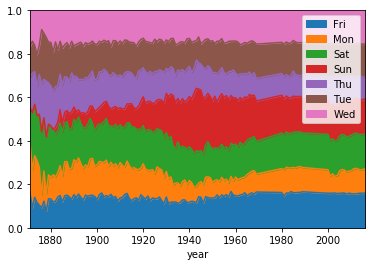

In [11]:
import matplotlib.pyplot as plt

data['date'] = pd.to_datetime(date, format='%Y%m%d')
data['year'] = data.date.dt.year

# Create a spreadsheet-style pivot table as a DataFrame
# example: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html
games_per_day = data.pivot_table(index='year', columns='day_of_week', values='date', aggfunc=len)
print games_per_day.shape

games_per_day = games_per_day.divide(games_per_day.sum(axis=1),axis=0)
print games_per_day.head()

ax = games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()